# Machine Learning II - Big Cats Image Classification - Final Project - Pleurat Ajrizi (Ajrizple)

### Import Statements

In [33]:
import numpy as np
import pandas as pd
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

### Function to process image file paths and labels

In [34]:
def proc_img(filepath):
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    filepath= pd.Series(filepath,name='Filepath').astype(str)
    labels=pd.Series(labels, name="Label")
    df=pd.concat([filepath,labels],axis=1)
    df=df.sample(frac=1).reset_index(drop=True)
    
    return df

### Load and process training, test and validation images

In [35]:
train_dir=Path('train')

filepath=list(train_dir.glob(r'**/*.jpg'))
df=proc_img(filepath)
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')
df.head()

Number of pictures: 2339

Number of different labels: 10

Labels: ['CHEETAH' 'SNOW LEOPARD' 'JAGUAR' 'LIONS' 'PUMA' 'CARACAL' 'OCELOT'
 'AFRICAN LEOPARD' 'TIGER' 'CLOUDED LEOPARD']


Filepath         Label
0       train\CHEETAH\095.jpg       CHEETAH
1  train\SNOW LEOPARD\215.jpg  SNOW LEOPARD
2        train\JAGUAR\210.jpg        JAGUAR
3         train\LIONS\210.jpg         LIONS
4          train\PUMA\152.jpg          PUMA

In [36]:
test_dir=Path('test')

filepath=list(test_dir.glob(r'**/*.jpg'))
test_df=proc_img(filepath)
print(f'Number of pictures: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(test_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')
test_df.head()

Number of pictures: 50

Number of different labels: 10

Labels: ['AFRICAN LEOPARD' 'JAGUAR' 'CHEETAH' 'PUMA' 'CLOUDED LEOPARD' 'OCELOT'
 'TIGER' 'SNOW LEOPARD' 'LIONS' 'CARACAL']


Filepath            Label
0  test\AFRICAN LEOPARD\4.jpg  AFRICAN LEOPARD
1           test\JAGUAR\3.jpg           JAGUAR
2  test\AFRICAN LEOPARD\3.jpg  AFRICAN LEOPARD
3          test\CHEETAH\2.jpg          CHEETAH
4             test\PUMA\5.jpg             PUMA

In [37]:
valid_dir=Path('valid')

filepath=list(valid_dir.glob(r'**/*.jpg'))
v_df=proc_img(filepath)
print(f'Number of pictures: {v_df.shape[0]}\n')
print(f'Number of different labels: {len(v_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')
v_df.head()

Number of pictures: 50

Number of different labels: 10

Labels: ['AFRICAN LEOPARD' 'JAGUAR' 'CHEETAH' 'PUMA' 'CLOUDED LEOPARD' 'OCELOT'
 'TIGER' 'SNOW LEOPARD' 'LIONS' 'CARACAL']


Filepath            Label
0     valid\SNOW LEOPARD\5.jpg     SNOW LEOPARD
1          valid\CHEETAH\2.jpg          CHEETAH
2  valid\CLOUDED LEOPARD\3.jpg  CLOUDED LEOPARD
3  valid\CLOUDED LEOPARD\1.jpg  CLOUDED LEOPARD
4           valid\JAGUAR\3.jpg           JAGUAR

### Display unique samples as an example

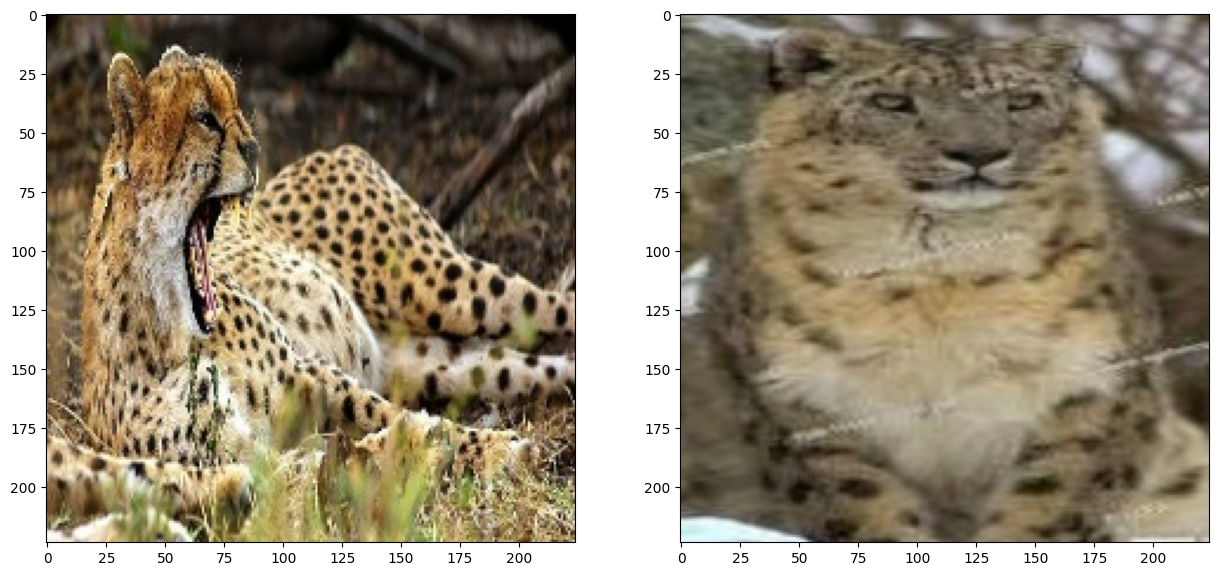

In [38]:
df_unique=df.copy().drop_duplicates(subset=['Label']).reset_index()

fig,axes=plt.subplots(ncols=2,figsize=(15,7))
for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
plt.show()

### Create data generators for training, validation, and testing


In [39]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,validation_split=0.2)
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

### Create training, validation and test image generator

In [40]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=v_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1872 validated image filenames belonging to 10 classes.
Found 10 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.


### Load pre-trained MobileNetV2 model

In [41]:

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

### Add custom layers to the model and train the model

In [42]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


c:\Users\pleur\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 352ms/step - accuracy: 0.6767 - loss: 1.1317 - val_accuracy: 1.0000 - val_loss: 0.0569
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - accuracy: 0.9544 - loss: 0.1493 - val_accuracy: 1.0000 - val_loss: 0.0420
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - accuracy: 0.9668 - loss: 0.0971 - val_accuracy: 1.0000 - val_loss: 0.0836
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - accuracy: 0.9839 - loss: 0.0664 - val_accuracy: 1.0000 - val_loss: 0.0565
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.9934 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 0.0122
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.9924 - loss: 0.0266 - val_accuracy: 1.0000 - val_loss: 0.0208
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - accuracy: 0.9977 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.0254
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 362ms/step - accuracy: 0.9984 - loss: 0.0122 - val_accuracy: 1.000

### Visualize training and validation accuracy

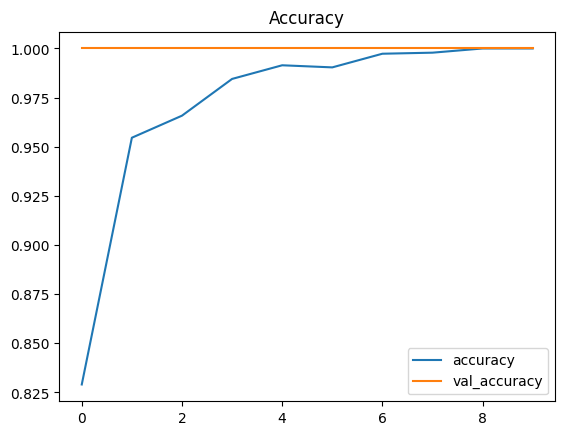

In [43]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

### Visualize training and validation loss

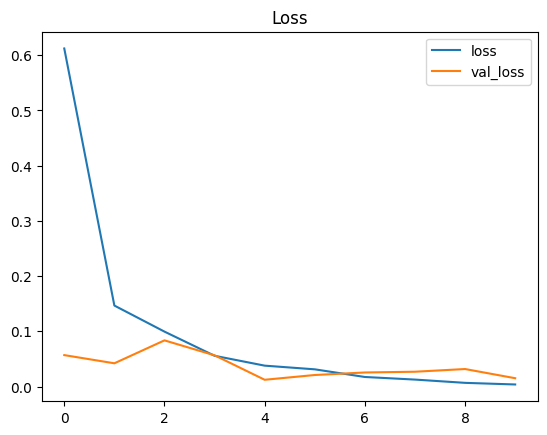

In [44]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

### Generate predictions for the test images

In [45]:

pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 5 predictions: {pred[:5]}')

c:\Users\pleur\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
The first 5 predictions: ['AFRICAN LEOPARD', 'JAGUAR', 'AFRICAN LEOPARD', 'CHEETAH', 'PUMA']


### Map predicted indices to actual label names and generate Classification Report

In [46]:

y_test = test_images.classes


pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)


labels = (train_images.class_indices)
labels_inverted = {v: k for k, v in labels.items()}
pred_labels = [labels_inverted[label] for label in pred]


y_test_labels = [labels_inverted[label] for label in y_test]


from sklearn.metrics import classification_report
class_report = classification_report(y_test_labels, pred_labels, zero_division=1)
print(class_report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
                 precision    recall  f1-score   support

AFRICAN LEOPARD       1.00      0.80      0.89         5
        CARACAL       1.00      1.00      1.00         5
        CHEETAH       0.83      1.00      0.91         5
CLOUDED LEOPARD       1.00      0.80      0.89         5
         JAGUAR       0.83      1.00      0.91         5
          LIONS       1.00      1.00      1.00         5
         OCELOT       1.00      1.00      1.00         5
           PUMA       1.00      1.00      1.00         5
   SNOW LEOPARD       1.00      1.00      1.00         5
          TIGER       1.00      1.00      1.00         5

       accuracy                           0.96        50
      macro avg       0.97      0.96      0.96        50
   weighted avg       0.97      0.96      0.96        50



### Calculate Model Accuracy on Test Set

In [47]:
from sklearn.metrics import accuracy_score


y_test = list(test_df.Label)


labels = (train_images.class_indices)
labels_inverted = {v: k for k, v in labels.items()}
pred_labels = [labels_inverted[label] for label in pred]


acc = accuracy_score(y_test, pred_labels)
print(f'Accuracy on the test set: {acc * 100:.2f}%')


Accuracy on the test set: 96.00%


### Create and Visualize Confusion Matrix to evaluate model performance on test set

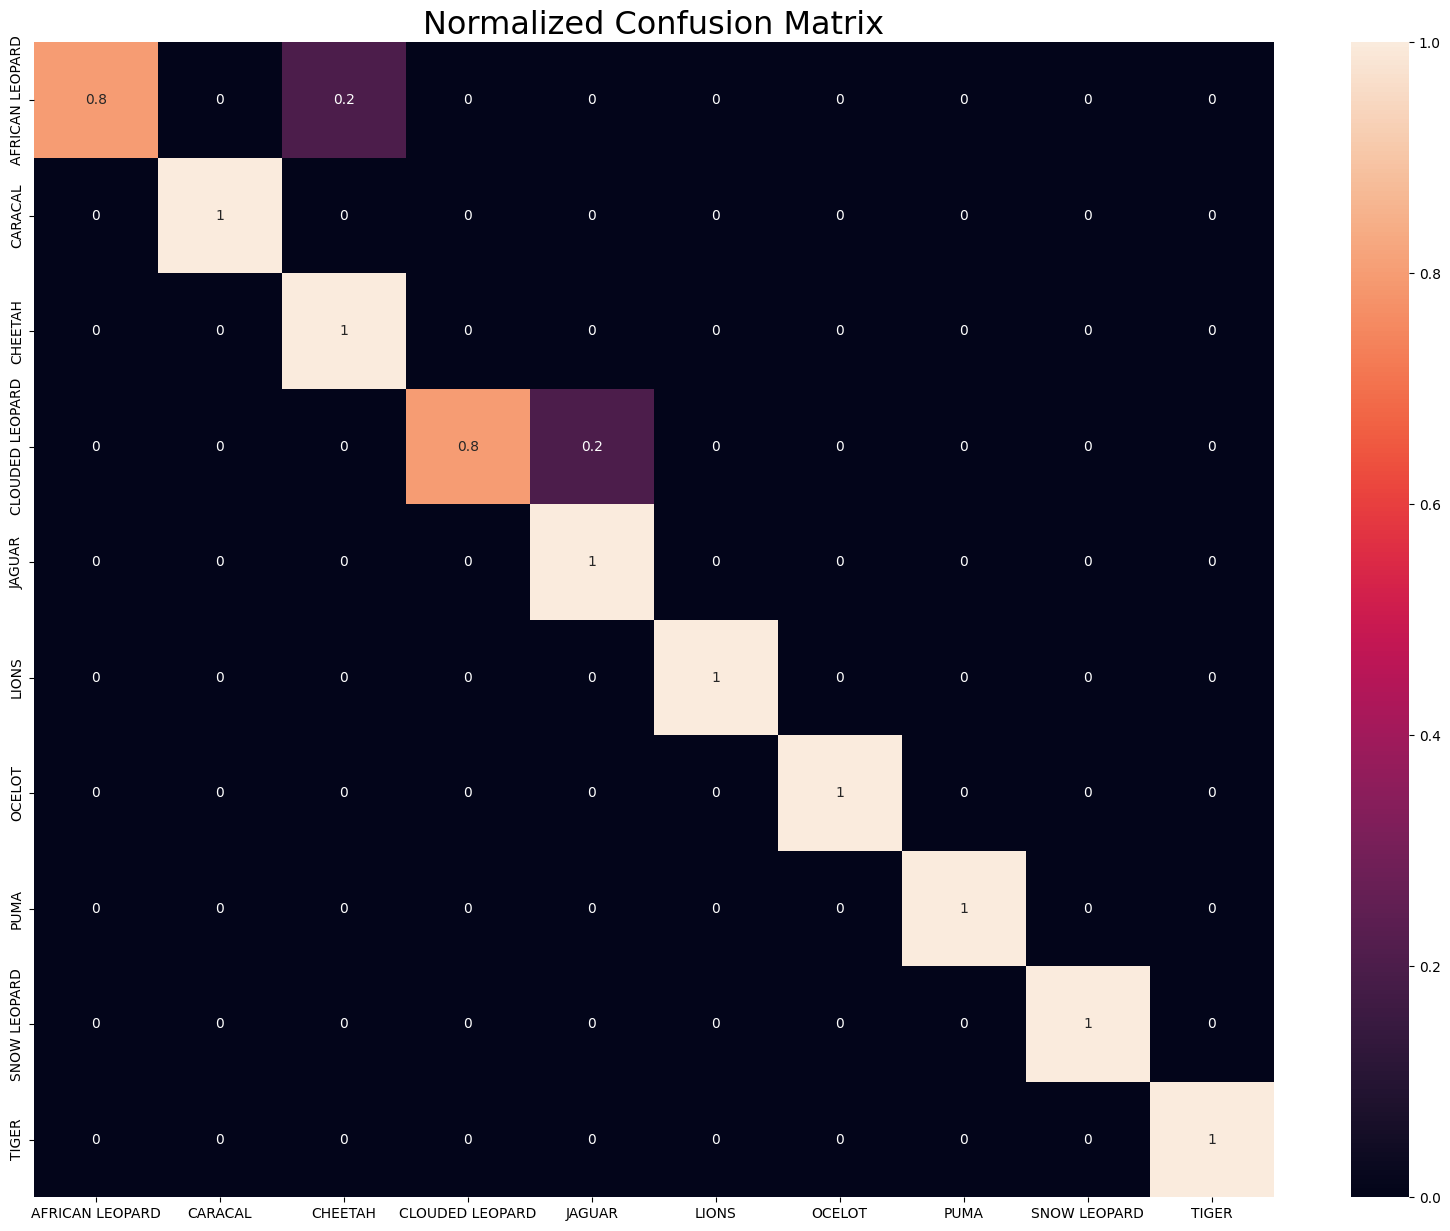

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_test_labels = list(test_df.Label)  


cf_matrix = confusion_matrix(y_test_labels, pred_labels, normalize='true')


plt.figure(figsize=(20, 15))
sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_test_labels)), yticklabels=sorted(set(y_test_labels)))
plt.title('Normalized Confusion Matrix', fontsize=23)
plt.show()


### Display 15 Images from the Test Dataset with their true and predicted Labels to demonstrate the outcome

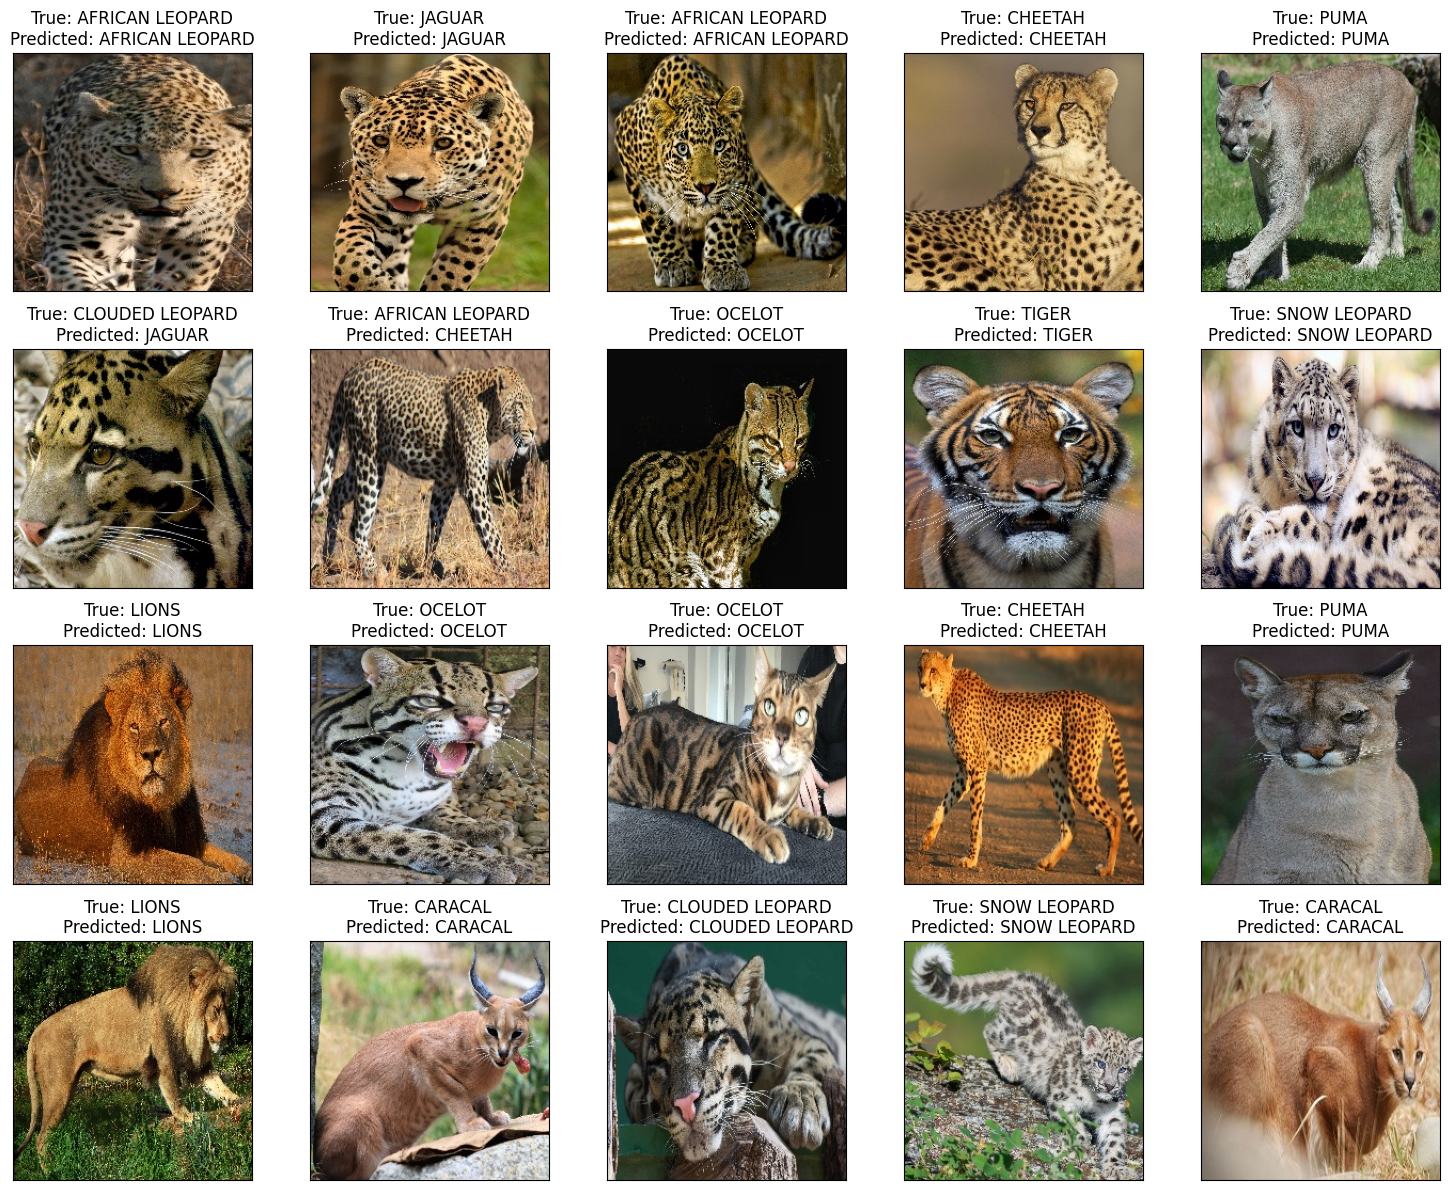

In [49]:

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(test_df):  
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred_labels[i]}")

plt.tight_layout()
plt.show()
